In [103]:
import math
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

### Assumptions

In [104]:
g = 9.81

rho_w = 1000 # density of water [kg/m^3]

rho_cc = 2850 # density of continental crust [kg/m^3]
rho_cm = 3338 # density of continental lithospheric mantle [kg/m^3]
cm = 200000 # thickness of continental  mantle

rho_oc = 2900 # density of oceanic crust
rho_om = 3300 # density of depleted oceanic lithospheric mantle
oc = 7000 # thickness of oceanic crust layer 
om = 50000 # thickness of depleted oceanic lithospheric mantle

rho_m = 3300 # density of asthenospheric mantle

### Isostatic balance equation
Isostatic balance equation (assume sea level = 0):

$$\rho_w w_B + \rho_{oc} d_{oc} + \rho_{om} d_{om} + \rho_m d_m = \rho_w w_A + \rho_{cc} d_{cc} + \rho_{cm} d_{cm}$$

- $\rho_i$ is the density of water, oceanic crust, (depleted) oceanic mantle, (asthenospheric) mantle, continental crust, etc.
- $d_i$ is the thickness of the oceanic crust, continental crust, etc.
- $w_B$ is the thickness of the water layer above the oceanic lithosphere
- $w_A$ is the thickness of the water layer above the continental lithosphere.


where the compensation depth is taken as the base of the continental lithospheric mantle, which determines the depth of the asthenospheric mantle ($d_m$).

Assuming $w_A = 0$:

$$\rho_w w_B + \rho_{oc} d_{oc} + \rho_{om} d_{om} + \rho_m d_m = \rho_{cc} d_{cc} + \rho_{cm} d_{cm}$$

Since we have two unknowns ($d_m$ and $w_B$), we use the equation:

$$d_{cc}+d_{cm} = w_B + d_{oc} + d_{om} + d_m$$

solving for $w_B$:
$$w_B = d_{cc} + d_{cm} - d_{om} - d_m - d_{oc}$$

substituting into the isostatic balance equation:

$$\rho_w(d_{cc} + d_{cm} - d_{om} - d_m - d_{oc}) + \rho_{oc} d_{oc} + \rho_{om} d_{om} + \rho_m d_m = \rho_{cc} d_{cc} + \rho_{cm} d_{cm}$$

solving for $d_m$:
$$d_m = \frac{d_{cc}(\rho_{cc} - \rho_w) + d_{cm}(\rho_{cm} - \rho_w) + d_{om}(\rho_w - \rho_{om}) + d_{oc}(\rho_w - \rho_{oc})}{\rho_m -\rho_w}$$

In [105]:
# varying the thickness of the continental crust
cc = np.array(range(30000,60000,5000))

# solving for the thickness of the asthenospheric mantle
m = (cc*(rho_cc-rho_w)+cm*(rho_cm-rho_w)+om*(rho_w-rho_om)+oc*(rho_w-rho_oc))\
/(rho_m-rho_w)

now solving for $w_B$:

In [106]:
w_B = cc + cm - om - m - oc
print("Crustal thickness, mantle thickness, water depth:")
for i, water in enumerate(w_B):
    print("[%.0f km, %.1f km, %.1f km]"%((cc[i]/1000),(m[i]/1000),(w_B[i]/1000)))

Crustal thickness, mantle thickness, water depth:
[30 km, 171.7 km, 1.3 km]
[35 km, 175.7 km, 2.3 km]
[40 km, 179.7 km, 3.3 km]
[45 km, 183.7 km, 4.3 km]
[50 km, 187.7 km, 5.3 km]
[55 km, 191.8 km, 6.2 km]


checking that this is indeed equal to the continental lithospheric layer:

In [107]:
print("Crustal thickness, oceanic lithosphere, continental lithosphere:")
for i in range(len(w_B)):
    print("[%.0f km, %i km, %i km]"%((cc[i]/1000),((w_B[i]+oc+om+m[i])/1000), ((cm+cc[i])/1000)))

Crustal thickness, oceanic lithosphere, continental lithosphere:
[30 km, 230 km, 230 km]
[35 km, 235 km, 235 km]
[40 km, 240 km, 240 km]
[45 km, 245 km, 245 km]
[50 km, 250 km, 250 km]
[55 km, 255 km, 255 km]


### Calculating the lithostatic pressure
$$P = \int_{a}^{b} \rho(z) g dz$$

#### Continental lithosphere

In [108]:
compensation_depth = cc + cm # compensation depth

initial_depth = 0
depth_increment = 1000
final_depth = compensation_depth+depth_increment
z = [[]]*len(cc)
for i, depth in enumerate(final_depth):
    z[i] = list(range(initial_depth,depth,depth_increment)) # depth [m]

In [109]:
def calc_pressure_continent(z, w, cc):
    """
    Calculates the lithostatic pressure of the  continental lithosphere
    given the depth (z), water layer above (w), and thickness
    of the continental crust (cc)
    """
    P = np.array([0]*len(z))
    for i, val in enumerate(z):
        if abs(val) <= w:
            # integrate the density over the water layer
            y, err = integrate.quad(lambda z: rho_w*g,0,val)
        elif w < abs(val) <= w + cc:
            # integrate the density over the crustal layer,
            # plus the total pressure from the water layer
            y, err = integrate.quad(lambda z: rho_cc*g,w,val)
            y+= rho_w*g*w
        elif w + cc <= abs(val) <= w + cc + cm:
            # integrate the density over the continental lithospheric mantle layer,
            # plus the total pressure from the water + crustal layer
            y, err = integrate.quad(lambda z: rho_cm*g,w+cc,val)
            y+= rho_w*g*w + rho_cc*g*cc
        else:
            # integrate the density over the mantle layer,
            # plus the total pressure from the water + crustal + cm layer
            y, err = integrate.quad(lambda z: rho_m*g,w+cc+cm,val)
            y+= rho_w*g*w + rho_cc*g*cc + rho_cm*g*cm
        P[i] = y/1e6
    return P

#### Oceanic lithosphere

In [110]:
def calc_pressure_ocean(z, w, oc):
    """
    Calculates the lithostatic pressure of the  oceanic lithosphere
    given the depth (z), water layer above (w), and thickness
    of the oceanic crust (oc)
    """
    P = np.array([0]*len(z))
    for i, val in enumerate(z):
        if abs(val) <= w:
            y, err = integrate.quad(lambda z: rho_w*g,0,val)
        elif w < abs(val) <= w+oc:
            y, err = integrate.quad(lambda z: rho_oc*g,w,val)
            y+= rho_w*g*w
        elif w+oc < abs(val) <= w+oc+om:
            y, err = integrate.quad(lambda z: rho_om*g,w+oc,val)
            y+= rho_w*g*w + rho_oc*g*oc
        else:
            y, err = integrate.quad(lambda z: rho_m*g,w+om+oc,val)
            y+= rho_w*g*w + rho_oc*g*oc + rho_om*g*om
        P[i] = y/1e6
    return P

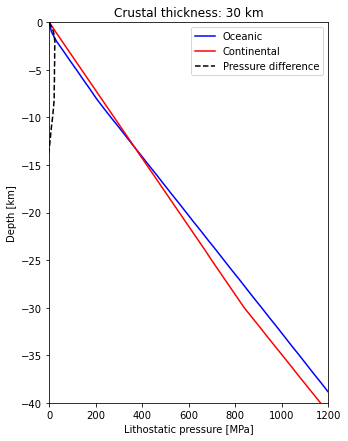

Maximum pressure difference: 24 MPa


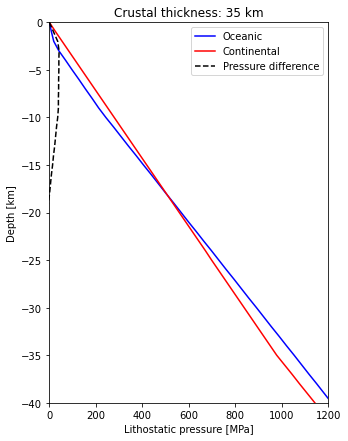

Maximum pressure difference: 42 MPa


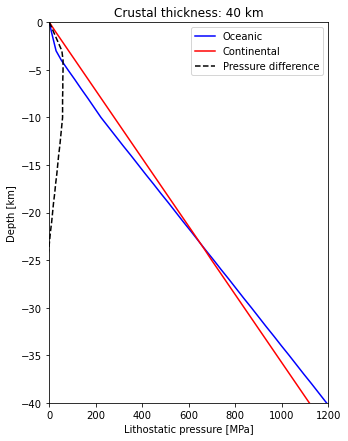

Maximum pressure difference: 59 MPa


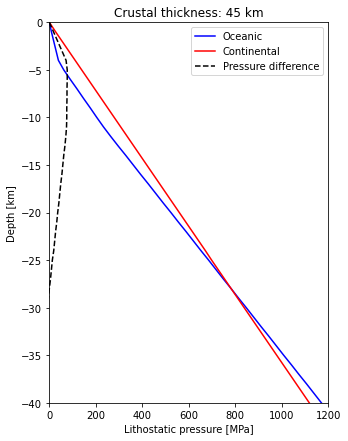

Maximum pressure difference: 77 MPa


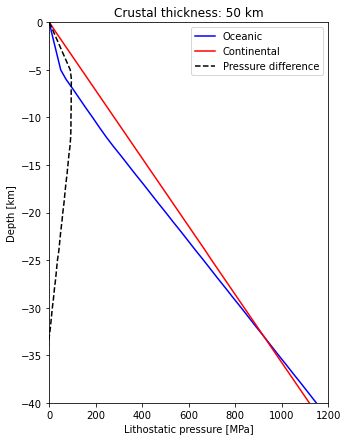

Maximum pressure difference: 95 MPa


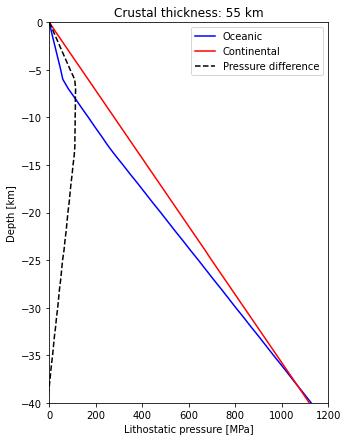

Maximum pressure difference: 113 MPa


In [115]:
# assuming that continents are at sea level
w_A = 0
P_A = [[]]*len(cc)
P_B = [[]]*len(cc)
P_diff = [[]]*len(cc)

for i, c in enumerate(cc):
    P_A[i] = calc_pressure_continent(z[i], w_A, c)
    P_B[i] = calc_pressure_ocean(z[i], w_B[i], oc)
    plt.figure(figsize=(5,7))
    plt.plot(P_B[i],[-j/1000 for j in z[i]],'b-')
    plt.plot(P_A[i],[-j/1000 for j in z[i]],'r-')
    P_diff[i] = P_A[i]-P_B[i] 
    plt.plot(P_diff[i],[-j/1000 for j in z[i]],'k--')
    plt.ylim((-40,0))
    plt.xlim((0,1200))
    plt.title('Crustal thickness: %i km'%(cc[i]/1000))
    plt.xlabel('Lithostatic pressure [MPa]')
    plt.ylabel('Depth [km]')
    plt.legend(['Oceanic','Continental','Pressure difference'])
    plt.show()
    print("Maximum pressure difference: %i MPa"%max(P_diff[i]))

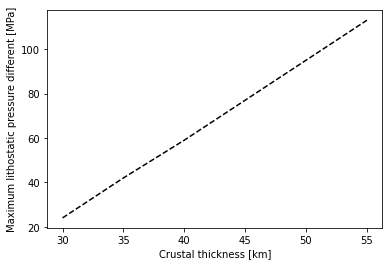

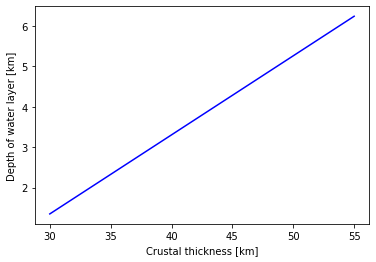

In [112]:
P_diff_max = []*len(cc)
for i in P_diff:
    P_diff_max.append(max(i))
    # print(P_diff_max)
plt.plot(cc/1000,np.array(P_diff_max),'k--')
plt.ylabel('Maximum lithostatic pressure different [MPa]')
plt.xlabel('Crustal thickness [km]')
plt.show()

plt.plot(cc/1000,w_B/1000,'b')
plt.ylabel('Depth of water layer [km]')
plt.xlabel('Crustal thickness [km]')
plt.show()

### Calculating the rate of radiogenic heat production $H$
#### Current Earth

In [51]:
K_con = ((1.5*10**4)/10**6)
K40_con = (1.28/10**4)*K_con
U_con = (1.3/10**6)
U238_con = 0.9927*U_con
U235_con = 0.0072*U_con
Th_con = (5.6/10**6)

K_heat = (2.79/10**5)*K40_con
U238_heat = (9.37/10**5)*U238_con
U235_heat = (5.69/10**4)*U235_con
Th_heat = (2.69/10**5)*Th_con

H = K_heat+Th_heat+U238_heat+U235_heat # rate of radiogenic heat production [W/kg]
print("Rate of radiogenic heat production: %.2e [W/Kg]"%H)

Rate of radiogenic heat production: 3.30e-10 [W/Kg]


#### Archean Earth

In [78]:
t = 3.5 # [Gyr]
K_con = ((1.5*10**4)/10**6)
K40_con = (1.28/10**4)*K_con*math.exp(0.555*t)

U_con = (1.3/10**6)
U238_con = 0.9927*U_con*math.exp(0.155*t)
U235_con = 0.0072*U_con*math.exp(0.985*t)

Th_con = (5.6/10**6)*math.exp(0.0495*t)

K_heat = (2.79/10**5)*K40_con
U238_heat = (9.37/10**5)*U238_con
U235_heat = (5.69/10**4)*U235_con
Th_heat = (2.69/10**5)*Th_con

H_archean = K_heat+Th_heat+U238_heat+U235_heat # rate of radiogenic heat production [W/kg]
print("H(t) at t = %.1f Ga: %.2e [W/Kg]"%(t, H_archean))

H(t) at t = 3.5 Ga: 9.28e-10 [W/Kg]


### Calculating Earth's geotherm
Starting with the heat equation
$$0 = k\frac{d^2T}{dz^2}+\rho H$$

where $H$ is rate of internal heat production ($W/kg$).

Integrate to get:
$$C = k\frac{dT}{dz}+\rho Hz$$

Integrate again:
$$D+Cz = kT + \frac{1}{2}\rho Hz^2$$

$$T = \frac{Cz}{k}-\frac{1}{2k}\rho Hz^2 + \frac{D}{k}$$

From the boundary condition that $T(z=0) = 0$, we have $D = 0$. The temperature gradient within the continental crust is:

$$T_1 = \frac{C_1}{k_1}z_1-\frac{1}{2k_1}\rho_1 Hz_1^2$$

where $C_1$ is the surface heat flow (from boundary condition $z = 0$)

The temperature at the base of the continental lithosphere is:
$$T_m = T_p + (d_{cc}+d_{cm})\left(\frac{\partial T}{\partial z}\right)$$

In [69]:
T_p = 1350 # potential temperature for the current Earth [C]
T_p_archean = 1600 # potential temperature of the Archean earth [C]
dT_dz = 0.5 # adiabatic gradient [K/km]
cc=35000 # thickness of continental crust
T_m = T_p + (cc+cm)/1000*dT_dz
T_m_archean = T_p_archean + (cc+cm)/1000*dT_dz
print("Assuming continental crustal thickness of %i [km] and continental lithospheric mantle thickness of %i [km]"%((cc/1000),(cm/1000)))
print("Mantle temperature: %i [C]"%T_m)
print("Archean mantle temperature: %i [C]"%T_m_archean)

Assuming continental crustal thickness of 35 [km] and continental lithospheric mantle thickness of 200 [km]
Mantle temperature: 1467 [C]
Archean mantle temperature: 1717 [C]


where the temperature potential of the mantle $T_p$ is $\sim 1350^{\circ}$C (now) and $1600^{\circ}$C (Archean)

We assume that the adiabatic gradient $\left(\frac{\partial T}{\partial z}\right) \sim 0.5$ K/km

Thus, $T_m \sim 1470^{\circ}$C (now) and $\sim 1720^{\circ}$C (Archean)

The temperature gradient below the continental crust is:
$$T_2 = \frac{C_2}{k_2}z_2+D_2$$

We have three unknowns ($C_1$, $C_2$, $D_2$) and three boundary conditions.

At $z_1 = z_2 = d_{cc}$, we require that:
$$T_1 = T_2$$

$$k_1\frac{dT_1}{dz_1} = k_2\frac{dT_2}{dz_1}$$

at $z_2 = d_{cc}+d_{cm}$, we have:
$$T_2 = T_m$$

1) Using $k_1\frac{dT_1}{dz_1} = k_2\frac{dT_2}{dz_1}$:

$$C_1-\rho_1 Hz\Bigg\vert_{z = z_1} = C_2\Bigg\vert_{z=z_1}$$

$$C_1-\rho_1 Hz_1 = C_2$$

2) Using $T_1 = T_2$:
$$\frac{C_1}{k_1}z_1 - \frac{1}{2k_1}\rho_1 Hz_1^2 = \frac{C_2}{k_2}z_1 + D_2$$

3) Using $T_2 = T_m$:
$$\frac{C_2}{k_2}z_2 + D_2 = T_m$$

Combining (2) and (3):
$$D_2 = T_m - \frac{C_2}{k_2}z_2$$

$$\frac{C_1}{k_1}z_1 - \frac{1}{2k_1}\rho_1 Hz_1^2 = \frac{C_2}{k_2}z_1 + T_m - \frac{C_2}{k_2}z_2$$

Writing $C_1$ in terms of $C_2$:
$$C_1 = \frac{C_2k_1}{k_2} - \frac{C_2k_1}{k_2}\frac{z_2}{z_1} + \frac{T_mk_1}{z_1} + \frac{1}{2}\rho_1 Hz_1$$

Solving for $C_2$ in (1):
$$C_1 = C_2 +\rho_1 Hz_1$$

$$C_2 + \rho_1 Hz_1 = \frac{C_2k_1}{k_2} - \frac{C_2k_1}{k_2}\frac{z_2}{z_1} + \frac{T_mk_1}{z_1} + \frac{1}{2}\rho_1 Hz_1$$

$$C_2 - \frac{C_2k_1}{k_2} + \frac{C_2k_1}{k_2}\frac{z_2}{z_1}= \frac{T_mk_1}{z_1} - \frac{1}{2}\rho_1 Hz_1$$


$$C_2\left(1 - \frac{k_1}{k_2} + \frac{k_1}{k_2}\frac{z_2}{z_1}\right) = \frac{T_mk_1}{z_1} - \frac{1}{2}\rho_1 Hz_1$$

$$C_2 = \frac{\left(\frac{T_mk_1}{z_1} - \frac{1}{2}\rho_1 Hz_1\right)}{\left(1 - \frac{k_1}{k_2} + \frac{k_1}{k_2}\frac{z_2}{z_1}\right)}$$

In [70]:
k_1 = 3.0 # Thermal conductivity of the crustal layer [W/mK] (assume constant)
k_2 = 3.0 # Thermal conductivity of the upper mantle
numerator = (T_m*k_1)/cc - (1/2)*rho_cc*H*cc
denominator = 1 - (k_1/k_2) + (k_1/k_2)*((cc+cm)/cc)
C_2 = numerator/denominator
print("C_2 = %.2f"%C_2)
numerator = (T_m_archean*k_1)/cc - (1/2)*rho_cc*H_archean*cc
denominator = 1 - (k_1/k_2) + (k_1/k_2)*((cc+cm)/cc)
C_2_archean = numerator/denominator
print("C_2 archean = %.2f"%C_2_archean)

C_2 = 0.02
C_2 archean = 0.02


calculating $C_1$ from $C_2$:
$$C_1 = C_2 +\rho_1 Hz_1$$

In [71]:
C_1 = C_2+rho_cc*H*cc
print("C_1 (surface heat flow): %.2f"%C_1)
C_1_archean = C_2_archean+rho_cc*H_archean*cc
print("C_1 archean: %.2f"%C_1_archean)

C_1 (surface heat flow): 0.05
C_1 archean: 0.11


calculating $D$ from $C_2$:
$$D_2 = T_m - \frac{C_2}{k_2}z_2$$

In [89]:
D_2 = T_m-(C_2*(cm))/k_2
print("D_2 = %.2f"%D_2)
D_2_archean = T_m_archean-(C_2_archean*(cm))/k_2
print("D_2 archean = %.2f"%D_2_archean)

D_2 = 382.21
D_2 archean = 715.46


In [95]:
def calc_geotherm(z,C_1,C_2,D_2,H):
    """
    Calculates the geothermal gradient up to depth (z),
    (for now) assuming that thermal conductivity is constant
    and that values for the crust and mantle are both k = 3.0
    """
    T = np.ones(len(z))
    T_0 = 0 # surface temperature [C]
    
    # index of end of crustal layer
    i = int(np.where(z==cc)[0])
    # temperature within the crust 
    for j, z_1 in enumerate(z[:i]):
        T[j] = T_0 + (C_1*z_1)/k_1  - ((rho_cc*H*z_1**2)/(2*k_1))
    # temperature below the crust
    for m, z_2 in enumerate(z[i:]):
        T[m+j+1] = ((z_2-cc)/k_2)*C_2 + D_2
    return T

<Figure size 432x288 with 0 Axes>

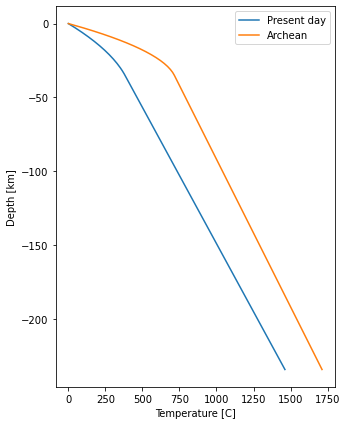

In [101]:
z = np.array(range(initial_depth,cc+cm,depth_increment))# depth [m]
T = calc_geotherm(z,C_1,C_2,D_2,H)
T_archean = calc_geotherm(z,C_1_archean,C_2_archean,D_2_archean,H_archean)
plt.figure(4)
plt.figure(figsize=(5,7))
plt.plot(T,[-i/1000 for i in z])
plt.plot(T_archean,[-i/1000 for i in z])
plt.xlabel('Temperature [C]')
plt.ylabel('Depth [km]')
plt.legend(['Present day','Archean'])
plt.show()